The focus of this notebook is to learn more about the `ARIMA` model from statsmodels to see how it works. We shall be usisng [this](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/#:~:text=The%20statsmodels%20library%20provides%20the,calling%20the%20fit()%20function.) as our source.

In [1]:
import os
import warnings
import datetime
from tqdm import tqdm

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from pandas.plotting import autocorrelation_plot

In [4]:
from statsmodels.tsa.arima.model import ARIMA

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [6]:
try:
    ### Local Storage
    df = pd.read_csv("./data/apple_stock.csv")
except:
    ### Alpha Vantage API
    # os.environ["ALPHA_VANTAGE_API_KEY"] ="0LQY2GPX91HZXOYZ" 
    API_KEY = os.getenv("ALPHA_VANTAGE_API_KEY")

    # Define the start date for the data retrieval
    start = datetime.datetime(2023, 1, 1)
    end = datetime.datetime.today()

    df = web.DataReader("AAPL", "av-daily", start=start, end=end, api_key=API_KEY)

In [39]:
df = df.set_index(pd.to_datetime(df['index'])).drop(columns='index')

## Points of Note

he parameters of the ARIMA model are defined as follows:
- p: The number of lag observations included in the model, also called the `lag order`.
- d: The number of times that the raw observations are differenced, also called the `degree of differencing`.
- q: The size of the moving average window, also called the `order` of moving average

## Check for Autocorrelation
This is helpful in determining the lag(p)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

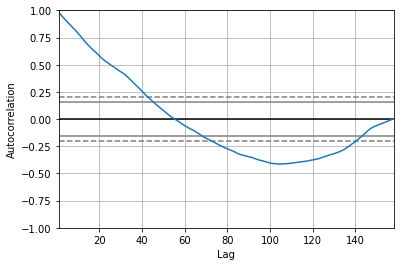

In [13]:
autocorrelation_plot(df.high)

The lag is positively correlated up to around `lag=50`.

In [16]:
# fit model
model = ARIMA(df.high, order=(5,1,0))
model_fit = model.fit()
residuals = model_fit.resid

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   high   No. Observations:                  158
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -339.330
Date:                Sat, 19 Aug 2023   AIC                            690.660
Time:                        11:49:52   BIC                            708.998
Sample:                             0   HQIC                           698.108
                                - 158                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0238      0.066      0.360      0.719      -0.106       0.153
ar.L2          0.0067      0.097      0.069      0.945      -0.184       0.198
ar.L3          0.0268      0.109      0.247      0.805      -0.186       0.240
ar.L4          0.0623      0.089      0.700      0.484      -0.112       0.237
ar.L5         -0.0786      0.080     -0.980      0.327      -0.236       0.079
sigma2         4.4127      0.435     10.146      0.000       3.560       5.265
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 7.00
Prob(Q):                              0.85   Prob(JB):                         0.03
Heteroskedasticity (H):               0.59   Skew:                             0.34
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

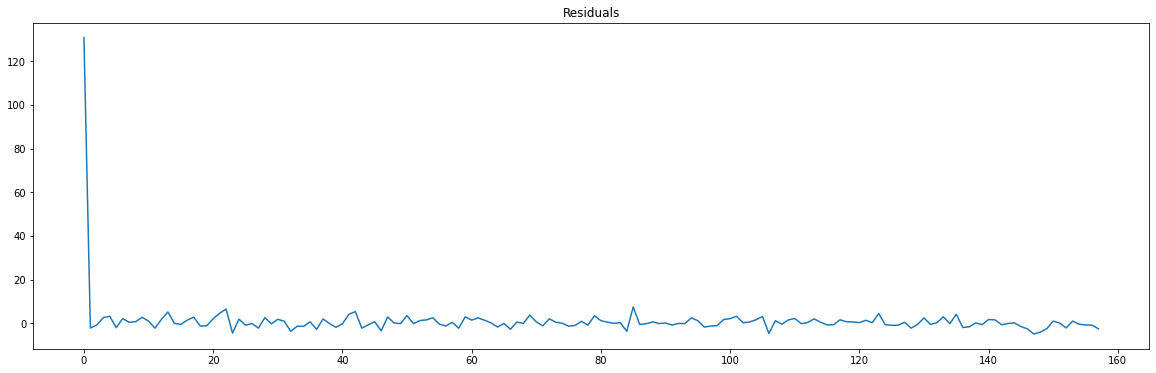

In [17]:
plt.figure(figsize=(20, 6))
plt.plot(residuals)
plt.title("Residuals")
plt.show()

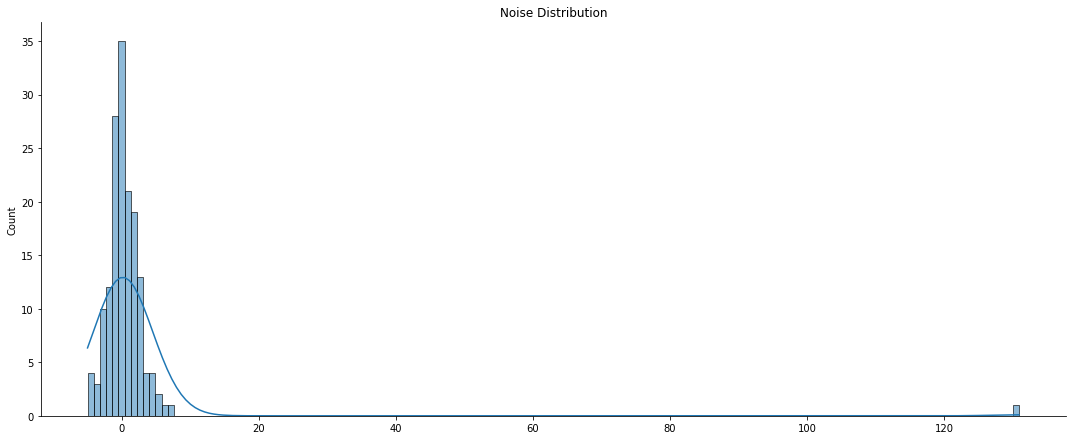

In [18]:
sns.displot(residuals, kde=True, height=6, aspect=2.5)
plt.title("Noise Distribution")
plt.show()

### Conclusion
The model seems to explain a lot of the variation as seen from the residual plot. We can also see that the `noise density plot` is `gaussian` as it should be. This is a satisfactory finding.

## Configuring an ARIMA model
> The classical approach for fitting an ARIMA model is to follow the `Box-Jenkins Methodology`. This is a process that uses time series analysis and diagnostics to discover good parameters for the ARIMA model.

Methods to optimize parameters include:
- GridSearch

### Helper Functions

In [19]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

In [20]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in tqdm(p_values):
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

### Train Test Split

In [40]:
tscv = TimeSeriesSplit(n_splits=2, test_size=len(df)//10)

for train_index, test_index in tscv.split(df):
    train = df.high[train_index]
    test = df.high[test_index]

### Grid Search

In [22]:
# EXECUTE
proceed = input("Perform Grid Search [y/n]?: ")
if proceed = 'y':
    p_values = [10, 20]
    d_values = range(0, 2)
    q_values = range(0, 2)
    warnings.filterwarnings("ignore")
    evaluate_models(train.values, p_values, d_values, q_values)
else:
    pass

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

ARIMA(10, 0, 0) MSE=3.382
ARIMA(10, 0, 1) MSE=3.226
ARIMA(10, 1, 0) MSE=3.090


 50%|██████████████████████████████████████████                                          | 1/2 [01:18<01:18, 78.58s/it]

ARIMA(10, 1, 1) MSE=3.099
ARIMA(20, 0, 0) MSE=3.730
ARIMA(20, 0, 1) MSE=3.322
ARIMA(20, 1, 0) MSE=3.293


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [06:59<00:00, 209.90s/it]

ARIMA(20, 1, 1) MSE=3.340
Best ARIMA(10, 1, 0) MSE=3.090


### Fit Best Model

In [41]:
model = ARIMA(df.high, order=(10, 1, 0))
model_fit = model.fit()

### Rolling Forecast

In [43]:
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(10,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t] # Requres that the index be a datetime object
	history.append(obs)
	print(f'predicted {yhat, obs}')

predicted 196.70778525473213
predicted 197.24967794547754
predicted 196.03462337567993
predicted 194.67417891389118
predicted 192.65450038141714
predicted 187.66122215451924
predicted 183.27486554109166
predicted 180.01661759511938
predicted 180.23699462349626
predicted 180.44793200766787
predicted 178.0206651453368
predicted 178.8623576302118
predicted 177.83012700816687
predicted 176.67765288534295
predicted 176.47364594530185


In [44]:
# Adding timestamps to predictions
predictions_ = pd.Series(predictions)
predictions_.index = test.index
predictions_

index
2023-07-31    196.707785
2023-08-01    197.249678
2023-08-02    196.034623
2023-08-03    194.674179
2023-08-04    192.654500
2023-08-07    187.661222
2023-08-08    183.274866
2023-08-09    180.016618
2023-08-10    180.236995
2023-08-11    180.447932
2023-08-14    178.020665
2023-08-15    178.862358
2023-08-16    177.830127
2023-08-17    176.677653
2023-08-18    176.473646
dtype: float64

In [45]:
# evaluate forecasts
rmse = mean_squared_error(test, predictions, squared=False)
print('Test RMSE: %.3f' % rmse)

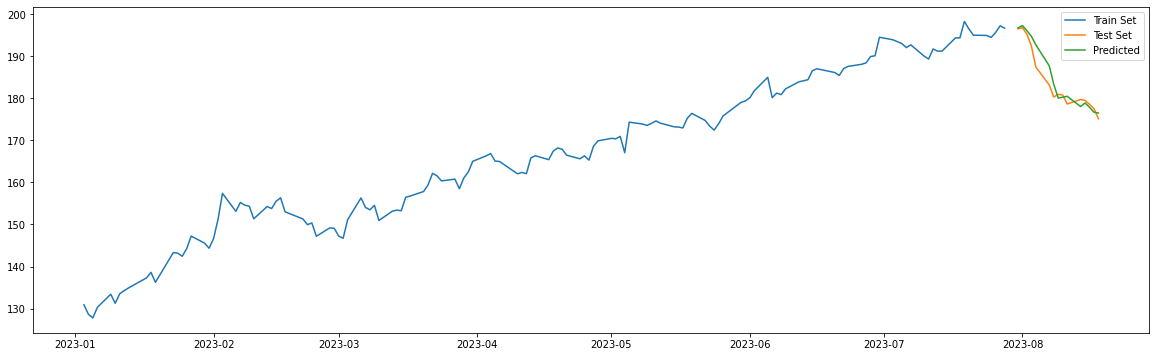

In [46]:
plt.figure(figsize=(20, 6))
plt.plot(train, label= "Train Set")
plt.plot(test, label="Test Set")
plt.plot(predictions_, label="Predicted")
plt.legend(loc='best')
plt.show()

## Conclusion
We have been able to predict accurately on the series. Of course the good prediction results from the fact that we are only predicting one step ahead at a time. Perhaps we can increase the number of time points to look ahead with better models.